In [1]:
import os
import re
import sys
import operator
from datetime import datetime
import pprint

game_started = re.compile("((?:\d+\.?){3} \d+:\d+:\d+.\d) : Game started")
game_stopped = re.compile("((?:\d+\.?){3} \d+:\d+:\d+.\d) : Game stopped")
betterlogs = re.compile("(?:\d+\.?){3} \d+:\d+:\d+.\d : 💡 BetterLogs: Joined player.* id: (\d+), name: (.*), ip: \d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}, auth: (.+)")
chatline = re.compile("(?:\d+\.?){3} \d+:\d+:\d+.\d : .*#\d+ : .*")
score_limit = re.compile("(?:\d+\.?){3} \d+:\d+:\d+.\d : 📢 : (.+)🏆 Лимит по очкам! .*")
time_limit = re.compile("(?:\d+\.?){3} \d+:\d+:\d+.\d : 📢 : (.+)🏆 Время вышло.*")
player_side = re.compile("(?:\d+\.?){3} \d+:\d+:\d+.\d : (.*) was moved to (\w{3,4})$")

def processing_nick(line): 
    if betterlogs.match(line):
        nick = betterlogs.match(line).group(2).strip()
        auth = betterlogs.match(line).group(3)     
        if auth not in players.keys():
            players[auth] = {nick : 1}
        else:
            if nick in players[auth].keys():
                players[auth][nick] += 1
            else:
                players[auth][nick] = 1

def starting_lineup(match):
    players = {'Red' : [], 'Blue': []}    
    for event in match:
        if game_started.match(event):
            break
        if player_side.match(event):
            players[player_side.match(event).group(2)].append(player_side.match(event).group(1).strip())
    return players


def match_result(match):
    winner = 0
    the_event = match[-1]    
    for m in reversed(match):
        if score_limit.match(m) or time_limit.match(m):
            the_event = m
            break
            
    if score_limit.match(the_event):
        if score_limit.match(the_event).group(1) == "🔵":
            winner = 2
        else: 
            winner = 1
    elif time_limit.match(the_event):
        if time_limit.match(the_event).group(1) == "🔵":
            winner = 2
        else: 
            winner = 1
    return winner


def get_goals(match, players):
    goals = {p:0 for p in players}
    for line in match:
        for name in sorted(players, key=len, reverse=True):
            if '⚽'+name in line and "| Автогол |" not in line: 
                goals[name] += 1
                break
    return goals
                
    
def get_stats(winner, players, m):
    player_stats = {p: {'goals': 0, 'wins' : 0} for p in players['Red'] + players['Blue']}
    if winner > 0 and len(players['Red']) == 4:
        if winner == 1:
            for p in players['Red']:
                player_stats[p]['wins'] += 1
        else: 
            for p in players['Blue']:
                player_stats[p]['wins'] += 1
        
        goals = get_goals(m, players['Red'] + players['Blue'])
        for p in goals.keys():
            player_stats[p]['goals'] += goals[p]
    else:
        return {'status' : '!4x4'}
    
    player_stats_auth = {}
    for k, v in player_stats.items():
        if k in stack_players.keys():
            player_stats_auth[stack_players[k].strip()] = v
    return {'stats': player_stats_auth}
        


def analyse_match():
    match = current_match['logs'] 
    match_players = starting_lineup(match)
    match_winner = match_result(match)
    match_stats = get_stats(match_winner, match_players, match)
    current_match.update(match_stats)    
    
def processing(line):
    global match_id, current_match, db_matches
    
    if not chatline.match(line) and not betterlogs.match(line):
        current_match['logs'].append(line.strip())
        
    if game_stopped.match(line):
        current_match['status'] = 'stopped'
        current_match['stopped_at'] = datetime.strptime(game_stopped.match(line).group(1), 
                                                      '%d.%m.%Y %H:%M:%S.%f')
        analyse_match()
        
        del(current_match['logs'])
        if current_match['status'] == 'stopped':
            db_matches.append(current_match)
        match_id += 1
        current_match = {'status' : 'init', 'id' : match_id, 'logs' : []}
    if game_started.match(line):
        current_match['status'] = 'in progress',
        current_match['start_at'] = datetime.strptime(game_started.match(line).group(1), 
                                                      '%d.%m.%Y %H:%M:%S.%f')
    
    if betterlogs.match(line):
        processing_nick(line)
        nickname = betterlogs.match(line).group(2).strip()
        auth_key = betterlogs.match(line).group(3)
        stack_players[nickname] = auth_key
        
match_id = 0
current_match = {'status' : '', 'id' : -1, 'logs' : []}
db_matches = []
stack_players = {}
players = {}

folder = 'dataHAX/all_files/'
for filename in sorted(os.listdir(folder)):
    f = os.path.join(folder, filename)
    with open(f, 'r', encoding='utf-8') as file:
        for line in file:
            processing(line)

print(len(db_matches), len(players))
#players = players['8zC-sxowXUIMFKZ2seldvc1vegZo'] = {'Roll.': 6, 'osa': 1,}
#db_matches = [...]

27368 17680


In [2]:
stats = {}
for match in db_matches:
    for auth, match_stats in match['stats'].items():
        if (match['start_at'].strftime('%Y-%m') , auth) not in stats.keys():
            stats[(match['start_at'].strftime('%Y-%m') , auth)] = {
                    'goals' : match_stats['goals'],
                    'matches' : 1,
                    'wins' : match_stats['wins'],
                    'duration' : match['stopped_at'] - match['start_at']
                }
        else:
            stats[(match['start_at'].strftime('%Y-%m') , auth)]['goals'] += match_stats['goals']
            stats[(match['start_at'].strftime('%Y-%m') , auth)]['matches'] += 1
            stats[(match['start_at'].strftime('%Y-%m') , auth)]['wins'] += match_stats['wins']
            stats[(match['start_at'].strftime('%Y-%m') , auth)]['duration'] += (match['stopped_at'] - match['start_at'])
        
        
#stats  monthly

In [3]:
users = {}
for k,v in dict(sorted(players.items(), key=lambda item: sum(item[1].values()),
                       reverse=True)).items():
    if max(v.items(), key=operator.itemgetter(1))[0] not in users.keys():
        users[max(v.items(), key=operator.itemgetter(1))[0]] = {
            'idkeys' : [k],
            'visits' : sum(v.values())}
    else:
        users[max(v.items(), key=operator.itemgetter(1))[0]]['idkeys'].append(k)
        users[max(v.items(), key=operator.itemgetter(1))[0]]['visits'] += sum(v.values())
    if sum(v.values()) < 15:
        break

users_invert = {}
for nick, data in users.items():
    for idkey in data['idkeys']:
        users_invert[idkey] = nick

#users - users['Mobley'] = {'idkeys': ['RAUkZskkzWKTno6S9mXi6KCgxHu6sdttDFPc...', '...'], 'visits': 716}
#users_invert - users_invert['zC-sxowXUIMFKZ2'] = 'Mobley'

# ELO
def ELO_calc(match_stats):
    win_elo = 0 
    lose_elo = 0
    K = 30
    for auth, stats in match_stats:
        if 'elo' not in users[users_invert[auth]].keys():
            users[users_invert[auth]]['elo'] = [1000]
        win_elo += stats['wins'] * users[users_invert[auth]]['elo'][-1]
        lose_elo += (1 - stats['wins']) * users[users_invert[auth]]['elo'][-1]
    for auth, stats in match_stats:
        if stats['wins'] == 1:
            E = 1 / (1+10 ** ((lose_elo/4 - users[users_invert[auth]]['elo'][-1])/400))
            users[users_invert[auth]]['elo'].append(round(users[users_invert[auth]]['elo'][-1] + K * (1 - E)))
        else:
            E = 1 / (1+10 ** ((win_elo/4 - users[users_invert[auth]]['elo'][-1])/400))
            users[users_invert[auth]]['elo'].append(round(users[users_invert[auth]]['elo'][-1] + K * (0 - E)))
    if 1 / (1+10 ** ((lose_elo/4 - win_elo/4)/400)) >= 0.5:
        return 1
    return 0


counter = 0
quess_counter = 0
for match in db_matches:
    flag = True   
    if len(match['stats'].keys()) == 8: 
        for auth in match['stats'].keys():
            if auth not in users_invert.keys():
                flag = False
                break
        if flag:
            counter += 1
            quess_counter += ELO_calc(match['stats'].items())
print(quess_counter/counter)

0.6310988544760289


In [4]:
# creating CSV

with open('dataHAX/stats_by_month_14mar.csv', 'w') as f:
    f.write('date, nickname, goals, matches, wins, spent_h\n')
    for k , v in stats.items():
        if k[1] in users_invert.keys():
            f.write('%s, "%s", %s, %s, %s, %s\n' % (k[0], users_invert[k[1]],
                                              v['goals'], v['matches'],
                                              v['wins'], round(v['duration'].total_seconds() / 3600)
                                             ))

In [20]:
for k in db_matches:
    if k['id'] == 66255:
        pass
        #pprint.pprint(k)

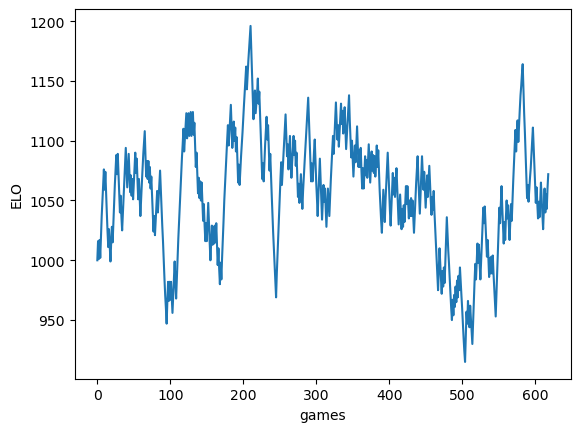

In [10]:
from matplotlib import pyplot as plt

plt.plot(users['корж']['elo'])
plt.xlabel('games')
plt.ylabel('ELO')
plt.show()

In [7]:
# longest match
for match in db_matches:
    if match['status'] == 'stopped':
        delta = (match['stopped_at'] - match['start_at'])
        if delta.seconds > 1000:
            print(delta.seconds / 60)
            
# list of nicks
for ids in users['корж']['idkeys']:
    print(players[ids])

22.95
{'кorg': 26, 'корж': 726, 'KORG': 1, 'key_organism': 1, 'korg': 9}
{'корж': 184}
{'корж': 45, 'подписав': 1}
